In [2]:
import phenoct

# Import sample
tube = phenoct.Tube(r"data/XRAYCT_V_X-020150-01_240909170158498_ears_1_200mm_084mu_0773-OBF-2-SH0004_240909185154927.rek")

uint16


In [3]:
# Run segmentation to remove tube and attenuation values below the set threshold
# start_slice - first slice to segment from top
# stop_slice - last slice to segment from top
# tube_r - tube radius, between 160-180
# tube_thickness - between 25-35
tube.segment_sample_holder(start_slice=750, stop_slice=2600, tube_r=170, tube_thickness=30, debug=False, attenuation_threshold = 2000)

Segmenting slice: 2599: 100%|██████████| 1850/1850 [00:11<00:00, 159.20it/s]


In [32]:
import numpy as np
import napari

raw = tube.data                # Original 3D volume
seg = tube.segmented_data      # Tube-removed 3D volume

viewer = napari.Viewer()
# Original data (cyan)
viewer.add_image(
    raw,
    name="raw",
    colormap="cyan",            # cyan colormap
    opacity=0.6,
    blending="additive",
)
# Segmented data (yellow)
viewer.add_image(
    seg,
    name="segmented",
    colormap="yellow",          # yellow colormap
    opacity=0.6,
    blending="additive",
)

removed = (raw > 0) & (seg == 0)
if removed.any():
    viewer.add_labels(
        removed.astype(np.uint8),
        name="removed_mask",
        opacity=0.4
    )

# Switch to 3D rendering mode
viewer.dims.ndisplay = 3

/opt/anaconda3/envs/napari-stable/lib/python3.10/site-packages/napari/_vispy/layers/scalar_field.py:197: UserWarning: data shape (2760, 406, 416) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(


/opt/anaconda3/envs/napari-stable/lib/python3.10/site-packages/napari/_vispy/layers/scalar_field.py:197: UserWarning: data shape (2760, 406, 416) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(


In [4]:
import numpy as np

vol = tube.segmented_data
print("type:", type(vol), "dtype:", vol.dtype, "shape:", vol.shape)

vmin, vmax = vol.min(), vol.max()
nnz = np.count_nonzero(vol)
print(f"min={vmin}, max={vmax}, nonzero={nnz}, nnz_ratio={nnz/vol.size:.6f}")

pos = vol[vol>0]
if pos.size > 0:
    qs = np.percentile(pos, [1,5,25,50,75,95,99])
    print("positive percentiles [1,5,25,50,75,95,99]:", qs)
else:
    print("WARNING: no positive voxels!")

type: <class 'numpy.ndarray'> dtype: uint16 shape: (2760, 406, 416)
min=0, max=19244, nonzero=3751262, nnz_ratio=0.008047
positive percentiles [1,5,25,50,75,95,99]: [ 2029.  2144.  2863.  4855. 10560. 15607. 16737.]


Total non-empty slices: 1848


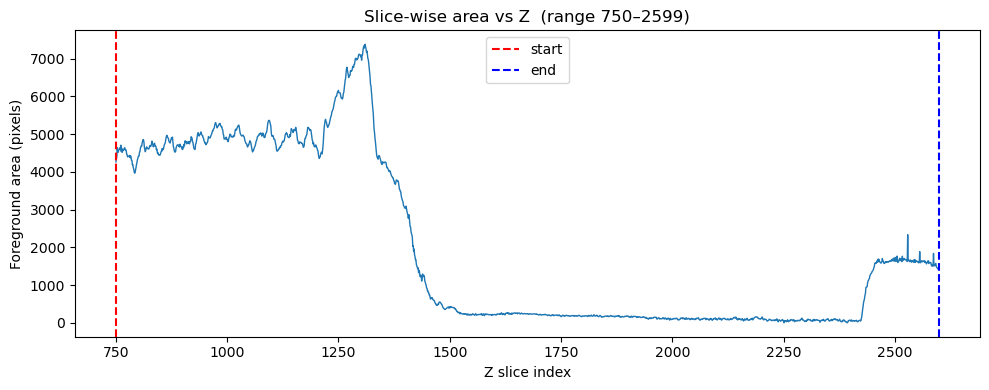

In [5]:
from matplotlib import pyplot as plt
import numpy as np

vol = tube.segmented_data
mask = (vol > 0)   # since threshold already applied

# count foreground pixels per Z slice
slice_area = mask.sum(axis=(1,2))  # shape = (Z,)
Z = mask.shape[0]

print("Total non-empty slices:", int(np.count_nonzero(slice_area)))

# find Z range that contains plant
nz = np.flatnonzero(slice_area > 0)
z_top, z_bot = (nz[0], nz[-1]) if nz.size else (0, 0)

plt.figure(figsize=(10,4))
plt.plot(np.arange(z_top, z_bot+1), slice_area[z_top:z_bot+1], linewidth=1)
plt.axvline(z_top, linestyle="--", color="red", label="start")
plt.axvline(z_bot, linestyle="--", color="blue", label="end")
plt.xlabel("Z slice index")
plt.ylabel("Foreground area (pixels)")
plt.title(f"Slice-wise area vs Z  (range {z_top}–{z_bot})")
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
import numpy as np

# --- knobs you can tune ---
SMOOTH_WIN = 21  # larger = smoother curve (was 15)
TOP_FRAC = 0.10  # top percent for spike_ref
BOT_FRAC = 0.10  # bottom percent for stem_ref
STABLE_W = 14  # consecutive slices required to confirm a plateau (was 10)

LOW_FRAC = 0.45  # area must stay below LOW_FRAC * spike_ref to confirm "post-spike low" (was 0.35)
HIGH_FRAC = 0.70  # area must stay above HIGH_FRAC * stem_ref to confirm "stem plateau" (was 0.60)

# safety margins to trim the peduncle head/tail after boundaries are found
# (either absolute slices or proportional; both are supported)
HEAD_MARGIN_SLICES = 12  # trim this many slices below spike_base
TAIL_MARGIN_SLICES = 12  # trim this many slices above flag_node
HEAD_MARGIN_FRAC = 0.03  # or trim 3% of (z_bot - z_top)
TAIL_MARGIN_FRAC = 0.03

# ------------- same inputs as before -------------
vol = tube.segmented_data
mask = vol > 0
slice_area = mask.sum(axis=(1, 2)).astype(float)
Z = slice_area.size

nz = np.flatnonzero(slice_area > 0)
if nz.size == 0:
    raise RuntimeError("No plant detected.")
z_top, z_bot = int(nz[0]), int(nz[-1])
span = z_bot - z_top + 1


# --- smoother moving average (odd window size recommended) ---
def smooth_1d(x, win=21):
    if win <= 1:
        return x.copy()
    k = np.ones(win, float) / win
    return np.convolve(x, k, mode="same")


area_s = smooth_1d(slice_area, win=SMOOTH_WIN)

# --- robust medians on top/bottom bands ---
top_hi = z_top + max(1, int(TOP_FRAC * span))
bot_lo = z_bot - max(1, int(BOT_FRAC * span)) + 1


def med_nonzero(a):
    a = a[a > 0]
    return float(np.median(a)) if a.size else 0.0


spike_ref = med_nonzero(area_s[z_top:top_hi])
stem_ref = med_nonzero(area_s[bot_lo : z_bot + 1])

# --- gradients for candidate change points ---
grad = np.diff(area_s)  # length Z-1
idx_drop = int(np.argmin(grad[z_top : z_bot - 1]) + z_top)  # steepest drop
# ensure the drop is within plant range
idx_drop = max(z_top, min(idx_drop, z_bot - STABLE_W - 2))

# LOW/HIGH thresholds (hysteresis idea)
low_th = max(1.0, LOW_FRAC * spike_ref)
high_th = max(1.0, HIGH_FRAC * stem_ref)

# --- refine spike_base: first stable-low window after the steep drop ---
spike_base = None
for z in range(idx_drop, z_bot - STABLE_W):
    win = area_s[z : z + STABLE_W]
    if win.size == STABLE_W and np.all(win < low_th):
        spike_base = z
        break
if spike_base is None:
    # fallback: search from top for first stable-low region
    for z in range(z_top, z_bot - STABLE_W):
        win = area_s[z : z + STABLE_W]
        if win.size == STABLE_W and np.all(win < low_th):
            spike_base = z
            break
if spike_base is None:
    spike_base = idx_drop

# --- refine flag_node: first stable-high window after spike_base ---
idx_rise = int(np.argmax(grad[spike_base : z_bot - 1]) + spike_base)
idx_rise = max(spike_base + 1, min(idx_rise, z_bot - STABLE_W - 1))

flag_node = None
for z in range(idx_rise, z_bot - STABLE_W):
    win = area_s[z : z + STABLE_W]
    if win.size == STABLE_W and np.all(win > high_th):
        flag_node = z
        break
if flag_node is None:
    # fallback: search from spike_base for first stable-high region
    for z in range(spike_base + 1, z_bot - STABLE_W):
        win = area_s[z : z + STABLE_W]
        if win.size == STABLE_W and np.all(win > high_th):
            flag_node = z
            break
if flag_node is None:
    flag_node = idx_rise

# ----------------- apply head/tail safety margins -----------------
# proportional margins
head_margin_prop = int(round(HEAD_MARGIN_FRAC * span))
tail_margin_prop = int(round(TAIL_MARGIN_FRAC * span))

# final margins (use the larger of absolute and proportional)
head_margin = max(HEAD_MARGIN_SLICES, head_margin_prop)
tail_margin = max(TAIL_MARGIN_SLICES, tail_margin_prop)

# trimmed peduncle z-range
z1 = max(z_top, spike_base + head_margin)
z2 = min(z_bot, flag_node - tail_margin)
if z2 <= z1:
    # guardrail: shrink margins if they collapse the interval
    shrink = max(1, (head_margin + tail_margin) // 2)
    z1 = max(z_top, spike_base + max(1, head_margin - shrink))
    z2 = min(z_bot, flag_node - max(1, tail_margin - shrink))
    
# cap peduncle length to at most 5 cm below z2 ----
SLICE_MM = 0.084  # mm per slice
MAX_LEN_MM = 50.0 # 5 cm = 50 mm
N5 = int(np.ceil(MAX_LEN_MM / SLICE_MM))  # number of slices for 5 cm (≈596)

z2 = min(z2, z1 + N5)   # choose the lower end so that length <= 5 cm

print(f"Plant Z range: [{z_top}, {z_bot}] (len={span})")
print(f"spike_ref ≈ {spike_ref:.1f}, stem_ref ≈ {stem_ref:.1f}")
print(f"Detected spike_base = {spike_base}, flag_node = {flag_node}")
print(f"Applied margins: head={head_margin} slices, tail={tail_margin} slices")
print(f"Final peduncle Z range: [{z1}, {z2}] (len={max(0, z2 - z1 + 1)})")

Plant Z range: [750, 2599] (len=1850)
spike_ref ≈ 4660.5, stem_ref ≈ 1618.2
Detected spike_base = 1418, flag_node = 2443
Applied margins: head=56 slices, tail=56 slices
Final peduncle Z range: [1474, 2070] (len=597)


Total non-empty slices: 1848


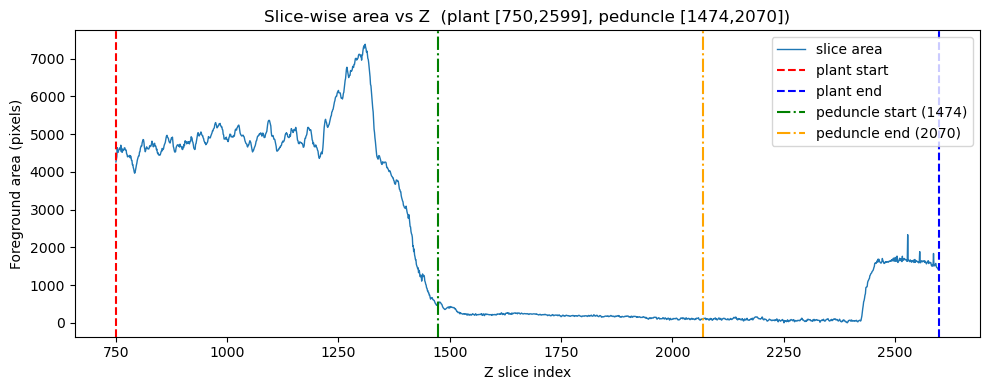

In [7]:
from matplotlib import pyplot as plt
import numpy as np

vol = tube.segmented_data
mask = (vol > 0)

slice_area = mask.sum(axis=(1,2))
Z = mask.shape[0]

print("Total non-empty slices:", int(np.count_nonzero(slice_area)))

nz = np.flatnonzero(slice_area > 0)
z_top, z_bot = (nz[0], nz[-1]) if nz.size else (0, 0)

plt.figure(figsize=(10,4))
plt.plot(np.arange(z_top, z_bot+1), slice_area[z_top:z_bot+1], linewidth=1, label="slice area")

# full plant range
plt.axvline(z_top, linestyle="--", color="red", label="plant start")
plt.axvline(z_bot, linestyle="--", color="blue", label="plant end")

# peduncle range (z1, z2 assumed already defined)
plt.axvline(z1, linestyle="-.", color="green", label=f"peduncle start ({z1})")
plt.axvline(z2, linestyle="-.", color="orange", label=f"peduncle end ({z2})")

plt.xlabel("Z slice index")
plt.ylabel("Foreground area (pixels)")
plt.title(f"Slice-wise area vs Z  (plant [{z_top},{z_bot}], peduncle [{z1},{z2}])")
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
vol = tube.segmented_data
mask = (vol > 0)

# build peduncle mask
peduncle_mask = np.zeros_like(mask, bool)
peduncle_mask[z1:z2+1] = mask[z1:z2+1]

# launch napari viewer
viewer = napari.Viewer(ndisplay=3)   # open directly in 3D mode

# add grayscale base
viewer.add_image(
    vol,
    name="segmented_data",
    colormap="gray",
    opacity=0.5,            # lower opacity so colored mask is visible
    blending="additive",
    rendering="attenuated_mip",  # other options: "mip", "translucent"
)

# add peduncle overlay (green, semi-transparent)
viewer.add_image(
    peduncle_mask.astype(np.float32),
    name="peduncle",
    colormap="green",
    contrast_limits=(0, 1),
    opacity=0.6,
    blending="translucent_no_depth",
)

/opt/anaconda3/envs/napari-stable/lib/python3.10/site-packages/napari/_vispy/layers/scalar_field.py:197: UserWarning: data shape (2760, 406, 416) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(
/opt/anaconda3/envs/napari-stable/lib/python3.10/site-packages/napari/_vispy/layers/scalar_field.py:197: UserWarning: data shape (2760, 406, 416) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(


<Image layer 'peduncle' at 0x37f7ecac0>

In [9]:
import numpy as np
from scipy.ndimage import label, generate_binary_structure
from skimage.morphology import remove_small_objects

vol = tube.segmented_data
mask = (vol > 0)

# Assume you already have z1, z2 (peduncle slice range)
ped_slab = np.zeros_like(mask, dtype=bool)
ped_slab[z1:z2] = mask[z1:z2]

# Step 1: Keep only the largest 3D connected component
ped_clean = remove_small_objects(ped_slab, min_size=3000, connectivity=3)

conn3d = generate_binary_structure(3, 2)  # 26-neighborhood
lab, nlab = label(ped_clean, structure=conn3d)
if nlab > 0:
    counts = np.bincount(lab.ravel())
    keep_label = counts[1:].argmax() + 1  # index of the largest component
    ped_main = (lab == keep_label)
else:
    ped_main = ped_clean

# Step 2 (optional): In each slice, keep only the largest 2D connected component
# ped_refined = np.zeros_like(ped_main, dtype=bool)
# for z in range(z1, z2):
#     sl = ped_main[z]
#     if sl.sum() == 0:
#         continue
#     lab2d, n2 = label(sl, structure=np.ones((3,3), bool))
#     if n2 == 0:
#         continue
#     cts = np.bincount(lab2d.ravel())
#     ped_refined[z] = (lab2d == (cts[1:].argmax()+1))

# If per-slice filtering is too strict, just use ped_main
ped_final = ped_main

print("Voxels before:", int(ped_slab.sum()))
print("After cleaning:", int(ped_final.sum()))

Voxels before: 118150
After cleaning: 113503


In [24]:
import napari

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(
    vol,
    name="segmented_data",
    colormap="gray",
    opacity=0.4,
    blending="additive",
    rendering="attenuated_mip",
)
viewer.add_image(
    ped_final.astype(np.float32),
    name="peduncle_clean",
    colormap="green",
    contrast_limits=(0, 1),
    opacity=0.7,
    blending="translucent_no_depth",
)

/opt/anaconda3/envs/napari-stable/lib/python3.10/site-packages/napari/_vispy/layers/scalar_field.py:197: UserWarning: data shape (2760, 406, 416) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(
/opt/anaconda3/envs/napari-stable/lib/python3.10/site-packages/napari/_vispy/layers/scalar_field.py:197: UserWarning: data shape (2760, 406, 416) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(


<Image layer 'peduncle_clean' at 0x3ea0d9f60>

In [70]:
import numpy as np

# vol = tube.segmented_data
# ped_final = your cleaned peduncle mask (bool), same shape as vol
ped_values = vol[ped_final]

print("Total voxels in peduncle:", ped_values.size)
print("Raw mean intensity:", ped_values.mean())

med = np.median(ped_values)
mad = np.median(np.abs(ped_values - med))
filtered = ped_values[np.abs(ped_values - med) < 1.5*mad]
robust_mean = filtered.mean()
print("MAD filtered mean:", robust_mean)

Total voxels in peduncle: 113503
Raw mean intensity: 2791.849158172031
MAD filtered mean: 2453.1330619241485


In [ ]:
import numpy as np

vol = tube.segmented_data
ped_mask = ped_final.astype(bool)

dz_mm = 0.084
px_xy_mm = 0.084

Z = vol.shape[0]

# ---- per-slice stats inside peduncle ----
area_px = ped_mask.sum(axis=(1, 2))  # per-slice area (pixels)
int_sum = np.zeros(Z, dtype=np.float64)  # per-slice integrated intensity (sum)
has_ped = area_px > 0

for z in np.flatnonzero(has_ped):
    m = ped_mask[z]
    int_sum[z] = vol[z][m].sum()

# ---- slice-level outlier removal by area (IQR) ----
area_mm2 = area_px * (px_xy_mm**2)
a = area_mm2[has_ped]
med = np.median(a)
mad = np.median(np.abs(a - med))
keep = np.abs(area_mm2 - med) < 2 * mad
valid = has_ped & keep

# ---- per-mm intensity curve on the kept slices ----
per_mm_intensity = np.zeros(Z, dtype=np.float64)
sel = np.flatnonzero(valid)
per_mm_intensity[sel] = int_sum[sel] / dz_mm

# ---- summary metric (one number) ----
per_mm_mean = per_mm_intensity[sel].mean() if sel.size else 0.0
per_mm_median = np.median(per_mm_intensity[sel]) if sel.size else 0.0

print(f"Kept slices: {sel.size} / {has_ped.sum()}")
print(f"Per-mm pixel intensity (mean over kept slices): {per_mm_mean:.2f}")
print(f"Per-mm pixel intensity (median over kept slices): {per_mm_median:.2f}")

Kept slices: 504 / 596
Per-mm pixel intensity (mean over kept slices): 5490404.36
Per-mm pixel intensity (median over kept slices): 5096226.19


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes
from skimage.morphology import binary_closing, disk

# Inputs
vol = tube.segmented_data
ped_mask = ped_final.astype(bool)   # ensure boolean
px_xy_mm = 0.084                    # XY pixel size (mm/px); change if different

Z = ped_mask.shape[0]
kept_z = []
thick_mm = []
R_mm_list = []
r_mm_list = []

for z in range(Z):
    sl0 = ped_mask[z]
    if not sl0.any():
        continue

    # 1) close tiny gaps (very light: disk radius = 1)
    sl = binary_closing(sl0, disk(1))

    # 2) fill holes -> outer shell
    outer = binary_fill_holes(sl)

    # 3) cavity of this slice (must exist to be kept)
    cavity = outer & (~sl)
    A_lumen_px = int(cavity.sum())
    if A_lumen_px <= 0:
        continue  # skip slices without a detected hole

    # 4) thickness from equivalent radii (outer minus lumen)
    A_outer_px = int(outer.sum())
    R_px = np.sqrt(A_outer_px / np.pi)
    r_px = np.sqrt(A_lumen_px / np.pi)
    t_mm = max((R_px - r_px) * px_xy_mm, 0.0)

    kept_z.append(z)
    thick_mm.append(t_mm)
    R_mm_list.append(R_px * px_xy_mm)
    r_mm_list.append(r_px * px_xy_mm)

kept_z = np.array(kept_z, dtype=int)
thick_mm = np.array(thick_mm, dtype=float)

print(f"Kept slices (with detectable lumen): {kept_z.size}")
if kept_z.size:
    print(f"Mean wall thickness:  {thick_mm.mean():.3f} mm")
    print(f"Median wall thickness:{np.median(thick_mm):.3f} mm")
else:
    print("No slices with a detectable lumen after closing.")


Kept slices (with detectable lumen): 313
Mean wall thickness:  0.353 mm
Median wall thickness:0.349 mm


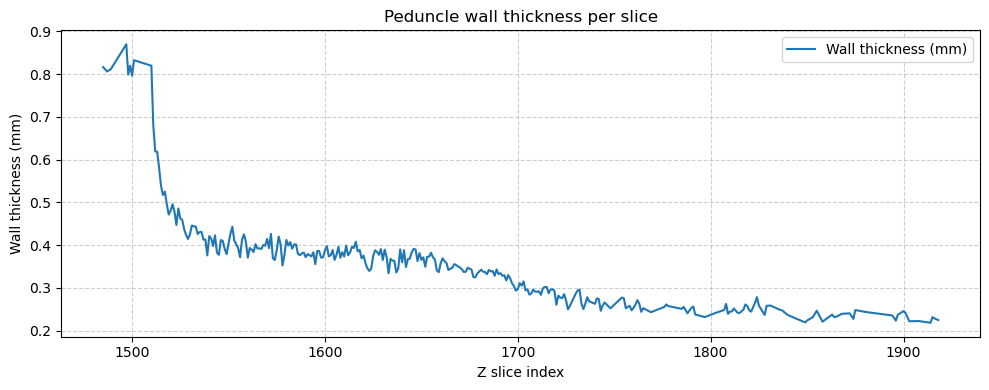

In [30]:

# --- plot thickness vs slice index (no height scaling) ---
if kept_z.size:
    plt.figure(figsize=(10,4))
    plt.plot(kept_z, thick_mm, lw=1.5, label="Wall thickness (mm)")
    plt.xlabel("Z slice index")
    plt.ylabel("Wall thickness (mm)")
    plt.title("Peduncle wall thickness per slice")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

In [27]:
# --- NEW: Napari visualization of the detected lumen ---
import napari

# Rebuild a 3D lumen mask only on kept slices (closing + fill)
lumen3d = np.zeros_like(ped_mask, dtype=bool)
for z in kept_z:
    sl0 = ped_mask[z]
    sl  = binary_closing(sl0, disk(1))
    outer = binary_fill_holes(sl)
    cavity = outer & (~sl)
    lumen3d[z] = cavity

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(
    vol, name="segmented_data",
    colormap="gray", opacity=0.5, blending="additive",
    rendering="attenuated_mip"
)
viewer.add_image(
    ped_mask.astype(np.float32), name="peduncle",
    colormap="green", contrast_limits=(0,1),
    opacity=0.45, blending="translucent_no_depth"
)
viewer.add_image(
    lumen3d.astype(np.float32), name="lumen",
    colormap="magenta", contrast_limits=(0,1),
    opacity=0.85, blending="translucent_no_depth"
)

/opt/anaconda3/envs/napari-stable/lib/python3.10/site-packages/napari/_vispy/layers/scalar_field.py:197: UserWarning: data shape (2760, 406, 416) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(
/opt/anaconda3/envs/napari-stable/lib/python3.10/site-packages/napari/_vispy/layers/scalar_field.py:197: UserWarning: data shape (2760, 406, 416) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(
/opt/anaconda3/envs/napari-stable/lib/python3.10/site-packages/napari/_vispy/layers/scalar_field.py:197: UserWarning: data shape (2760, 406, 416) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(


<Image layer 'lumen' at 0x37a2134f0>